## <center>**`Project Details`**</center>

#### **Purpose**:

Our goal is to build a chatbot from scratch with LangGraph, FastAPI & Streamlit. The conversation flows will be managed with LangGraph and we will use FastAPI to serve the chatbot endpoint. We will finnaly build a Streamlit UI to interact with the backend API.

#### **Constraints**:

 - Use local **ollama**


#### **Tools**:

 - None

#### **Requirements**:
 - Make it work as expected


***

## <center>**`Implementation`**</center>

### **`Backend`**

#### Utils functions

In [3]:
#%%writefile ../backend/utils/model_params.py
# model variables
MODEL_URL = "http://ollama:11434"
MODEL_NAME = "llama3.2"
MODEL_TEMP = 0.0
SYSTEM_PROMPT = "You are a helpful assistant."

In [4]:
#%%writefile ../backend/utils/model_provider.py

from langchain_ollama import ChatOllama
#from utils.model_params import MODEL_URL, MODEL_NAME, MODEL_TEMP

def load_model(url:str=MODEL_URL, model_name: str=MODEL_NAME, temperature:float=MODEL_TEMP, **kwargs):
    """Load local ollama model"""
    return ChatOllama(base_url=url, model=model_name, temperature=temperature, **kwargs)

#### Core

##### State variable

In [5]:
#%%writefile ../backend/core/state.py
from typing import TypedDict, Dict, Any, Annotated, Sequence, Optional
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class ChatState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    session_id : Optional[str] = None

##### Nodes

In [6]:
#%%writefile ../backend/core/nodes.py

#from core.state import ChatState
#from utils.model_provider import load_model
#from utils.model_params import MODEL_URL, MODEL_NAME, MODEL_TEMP, SYSTEM_PROMPT
from langchain_core.messages import SystemMessage


class ChatNode:
    def __init__(self, url:str=MODEL_URL,
                 model_name:str=MODEL_NAME,
                 temperature:float=MODEL_TEMP,
                 system_prompt:str=SYSTEM_PROMPT):
        self.systeme_message = SystemMessage(content=system_prompt)
        self.model = load_model(url, model_name, temperature)

    def run(self, state: ChatState) -> ChatState:
        messages = state["messages"]

        if not messages or type(messages[0]) != SystemMessage:
            messages.insert(0, self.systeme_message)

        response = self.model.invoke(messages)
        state["messages"].append(response)
        return state

##### The graph

In [7]:
#%%writefile ../backend/core/graph.py

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
#from core.state import ChatState
#from core.nodes import ChatNode
from IPython.display import Image, display
from typing import Optional
from langchain_core.runnables import RunnableConfig

class ChatGraph:
    def __init__(self):
        # nodes
        self.chat_node = ChatNode()

        # memory saver
        self.memory_saver = MemorySaver()

    def graph_builder(self):
        graph_builder = StateGraph(ChatState)

        # Nodes
        graph_builder.add_node("chat_agent", self.chat_node.run)

        # Edges
        graph_builder.add_edge(START, "chat_agent")

        # return compiled graph
        return graph_builder.compile(checkpointer=self.memory_saver)
    
    @property
    def graph(self):
        if hasattr(self, "_graph"):
            return self._graph
        self._graph = self.graph_builder()
        return self._graph
    
    def display(self):
        display(Image(self.graph.get_graph(xray=True).draw_mermaid_png()))

    def invoke(self, input:str, config: Optional[RunnableConfig]=None):
        return self.graph.invoke(input, config)

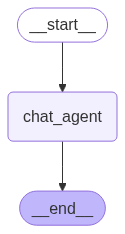

In [8]:
graph = ChatGraph()
graph.display()

##### Data models for (backend) api

In [34]:
#%%writefile ../backend/api/models.py
from pydantic import BaseModel, Field

class ChatRequest(BaseModel):
    user_input: str
    recursion_limit: int=Field(default=25)

class ChatResponse(BaseModel):
    response: str
    session_id: str

##### Backend logic

In [ ]:
%%writefile ../backend/api/main.py
from fastapi import FastAPI, HTTPException
import logging
from typing import Dict, Any
from api.models import ChatRequest, ChatResponse
from core.graph import ChatGraph
import uuid
import traceback
from langchain_core.messages import HumanMessage


# configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# define the app
app = FastAPI(
    title="Smart AI Chat Agent API",
    description="API for interacting with the smart chatbot",
    version="1.0.0"
)

# store chat sessions
chat_sessions : Dict[str, Dict[str, Any]] = {}

# end points
@app.post("/chat/start", response_model=ChatResponse)
async def start_chat(request: ChatRequest):
    """Start a new chat session with the chatbot"""
    try:
        # create a new graph instance
        graph = ChatGraph()

        # generate a unique session id
        session_id = str(uuid.uuid4())

        # run a chat by invoking the graph
        inputs = {"messages":[{"role":"user",
                               "content":request.user_input}]}
        
        config = {
            "recursion_limit":request.recursion_limit,
            "configurable":{"thread_id":session_id}
            }

        output = graph.invoke(
            input=inputs,
            config=config
        )

        # store the graph instance
        chat_sessions[session_id] = {
            "graph": graph,
            "state": output,
            "config": config
        }

        return ChatResponse(
            response=output["messages"][-1].content,
            session_id=session_id
        )
    except Exception as e:
        logger.error(f"Error starting chat: {traceback.format_exc()}")
        raise HTTPException(status_code=500, detail=traceback.format_exc())
    
# continue chat
@app.post("/chat/{session_id}/continue", response_model=ChatResponse)
async def continue_chat(session_id:str, request:ChatRequest):
    if session_id not in chat_sessions:
        raise HTTPException(status_code=404, detail="Session not found")
    
    # retrieve session and add user input
    chat_session = chat_sessions[session_id]
    chat_session["state"]["messages"].append(HumanMessage(content=request.user_input))

    # submit to chat
    new_state = chat_session["graph"].invoke(chat_session["state"], chat_session["config"])

    # update session
    chat_sessions[session_id].update({"state": new_state})

    return ChatResponse(
        response=new_state["messages"][-1].content,
        session_id=session_id
    )

#### Frontend

In [28]:
%%writefile ../frontend/chatbot_ui.py
import streamlit as st
import requests

# FastAPI server Url
API_URL = "http://127.0.0.1:8000" # To change when deployed

st.title("Smart chatbot")

# Session state for chat history
if "session_id" not in st.session_state:
    st.session_state.session_id = None
if "messages" not in st.session_state:
    st.session_state.messages = []

# display chat history
for message in st.session_state.messages:
    role = "user" if message["role"] == "user" else "ai"
    st.chat_message(role).write(message["content"])

# user input field
user_input = st.chat_input("Ask me anything")

if user_input:
    # Add user message to chat history and display it directly
    st.session_state.messages.append({"role": "user", "content": user_input})
    st.chat_message("user").write(user_input)

    # Detect if the session is new or not
    if st.session_state.session_id is None:
        # Start a new chat session
        response = requests.post(f"{API_URL}/chat/start", json={"user_input":user_input})
        if response.status_code == 200:
            data = response.json()
            st.session_state.session_id = data.get("session_id")
            ai_response = data.get("response")
            st.session_state.messages.append({"role":"ai", "content":ai_response})
            st.chat_message("ai").write(ai_response)

        else:
            st.error("Failed to start chat session.")
    else:
        # Continue an existing chat
        response = requests.post(f"{API_URL}/chat/{st.session_state.session_id}/continue",
                                 json={"user_input":user_input})
        
        if response.status_code == 200:
            data = response.json()
            ai_response = data.get("response")
            st.session_state.messages.append({"role":"ai", "content":ai_response})
            st.chat_message("ai").write(ai_response)
        else:
            st.error("Failed to continue chat.")

Overwriting ../frontend/chatbot_ui.py
